In this notebook, we apply GMM-MI to a synthetic Gaussian mixture model, calculating the MI residuals over different realisations of the ground truth. We consider a dataset with 3 components, D3.

### Import packages

In [1]:
import numpy as np
import os
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.gmm import GMMWithMI as GMM
from gmm_mi.data.synthetic_data import D3 as dataset
from gmm_mi.utils.plotting import plot_gmm_contours, plot_bias_chi2_histogram

### Calculate the true MI of the synthetic model, and plot contours

True MI: 0.132 nats


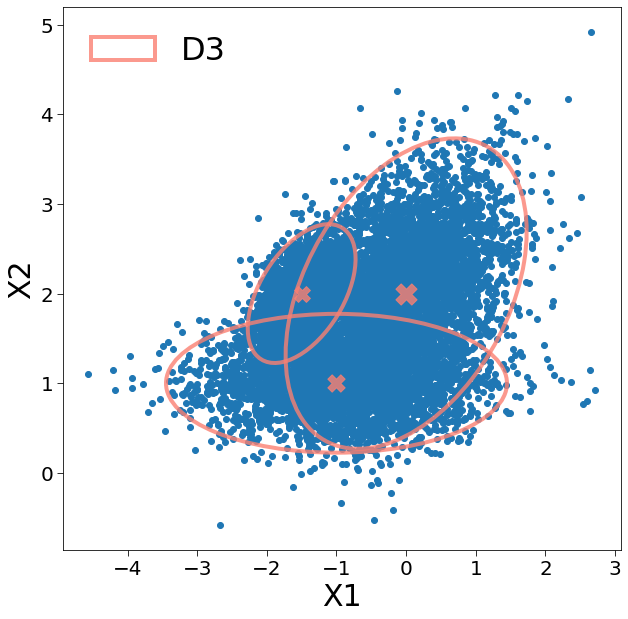

In [2]:
label = 'D3'
analytic = np.load(f'./MI_synthetic_datasets/MI_{label}.npy')
print(f'True MI: {analytic:.3f} nats')
plot_gmm_contours(dataset, ls='-', label=label)

### Test on 501 trials

In [3]:
# parameters for synthetic GMM datasets, notebooks 1-4
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-6,
                                   reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=10,
                                                       n_folds=5)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e5)

In [4]:
random_states = 501
N = 10000
results_file = f'./results/MI_{label}_{random_states}.npy'

if os.path.isfile(results_file) :
    print('Not running this cell, since results file already exists. '
          'Loading pre-computed results...')
    all_MI_estimates = np.load(results_file)
else:
    print(f'Estimating MI, and saving results...')
    all_MI_estimates = np.zeros((random_states, 2))

    # true GMM parameters
    n_components = dataset.n_components 
    true_weights = dataset.weights_
    true_means = dataset.means_
    true_covariances = dataset.covariances_
    
    for r in range(random_states):
        # create different realisation of ground truth; note the different random_state each time
        X = GMM(n_components=n_components, weights_init=true_weights, 
                          means_init=true_means, covariances_init=true_covariances, 
                          random_state=r).sample(N)[0]  
            
        mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                  select_components_params=select_components_params,
                                  mi_dist_params=mi_dist_params)
        MI_mean, MI_std = mi_estimator.fit(X)   
            
        all_MI_estimates[r, 0] = MI_mean
        all_MI_estimates[r, 1] = MI_std

        np.save(results_file, all_MI_estimates)

Not running this cell, since results file already exists. Loading pre-computed results...


### Evaluate MI bias

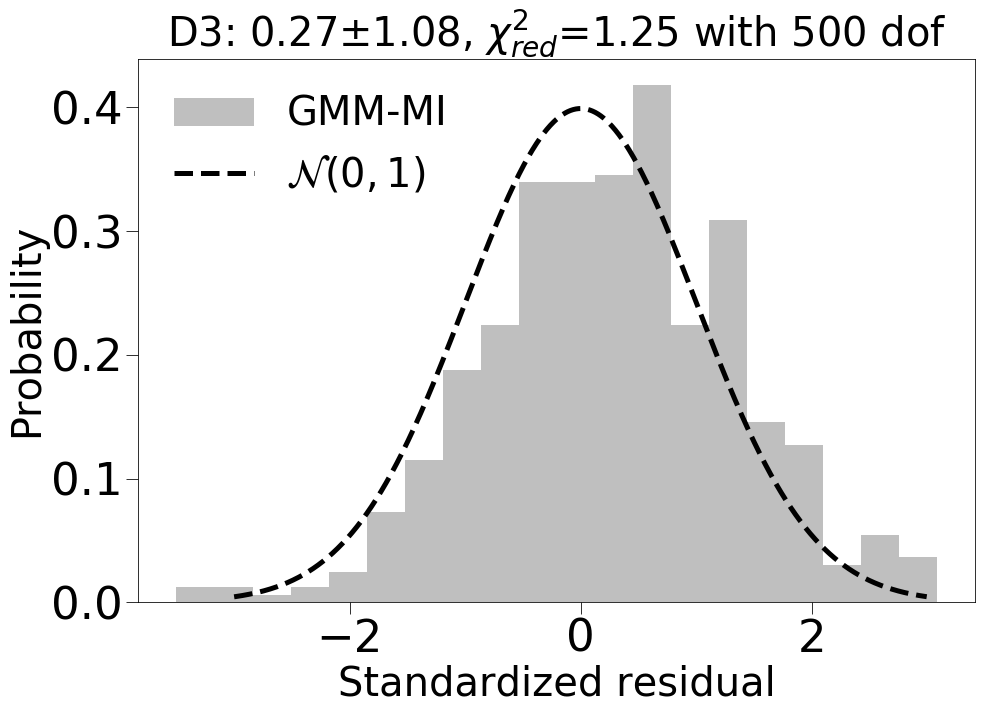

In [5]:
show_title=True
show_legend=True
hide_ylabel=False
labelfontsize=40
legendsize=40

biases, red_chi2, df = plot_bias_chi2_histogram(all_MI_estimates, analytic=analytic, 
                                                show_title=show_title, show_legend=show_legend, 
                                                hide_ylabel=hide_ylabel, labelfontsize=labelfontsize, 
                                                ds=label, legendsize=legendsize)

### Paper figure

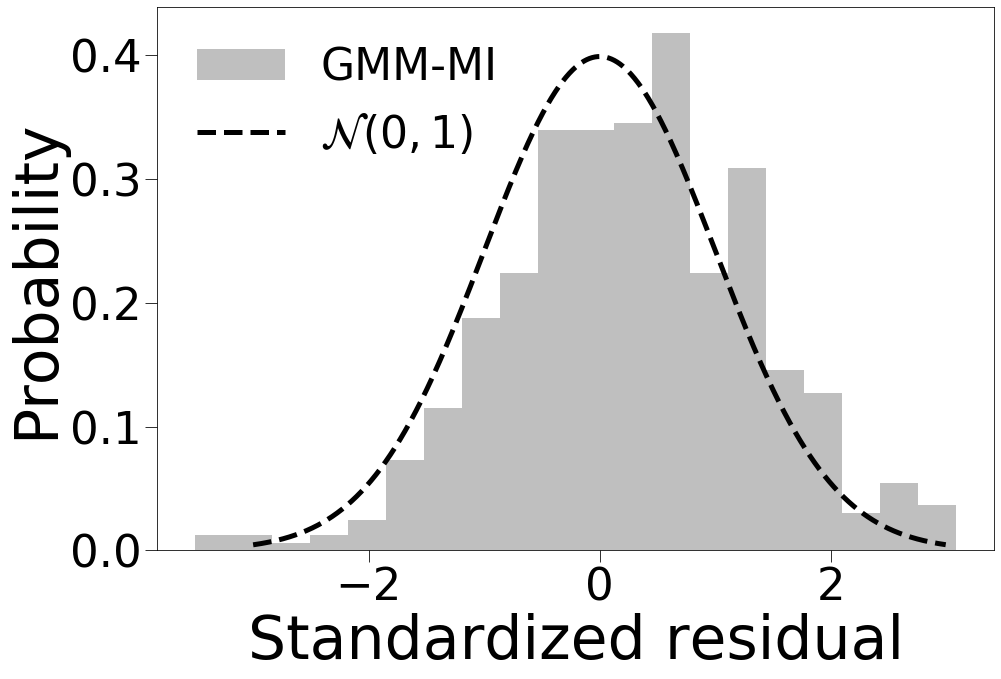

In [6]:
show_title=False
show_legend=True
hide_ylabel=False
savefig=True
savepath=f'./figures/{label}_residuals.pdf'

biases, red_chi2, df = plot_bias_chi2_histogram(all_MI_estimates, analytic=analytic, 
                                                show_title=show_title, show_legend=show_legend, 
                                                hide_ylabel=hide_ylabel, ds=label, 
                                                savefig=savefig, savepath=savepath)